# Reinforcement Learning- and FEM-based Inverse Design

## Experiment Logger

In [1]:
import os
import neptune.new as neptune
from neptune.new.types import File
from neptune.new.utils import stringify_unsupported

os.environ['NEPTUNE_PROJECT']="pil-clemson/metamtl-rl"
os.environ['NEPTUNE_NOTEBOOK_ID']="45d03d69-6ac7-41ca-8af8-80caaa73aad5"
os.environ['NEPTUNE_NOTEBOOK_PATH']="metamaterial-rl/RemoteFEM-DQN.ipynb"

exp = None

In [2]:
experiment_repeat = 2

## Import

In [4]:
from __future__ import annotations
from typing import Union, Optional, Callable, Any
from typing import Tuple, List, Set, Dict
from typing import NamedTuple
from typing import Generator

In [5]:
from collections import defaultdict, deque
from types import SimpleNamespace
import queue
from queue import PriorityQueue
from enum import Enum

In [6]:
from dataclasses import dataclass, field

In [7]:
import traceback
import tracemalloc

In [8]:
import ipywidgets as widgets
from IPython.display import clear_output

In [9]:
import os
import sys
import copy
import time
from datetime import datetime, timedelta
from pprint import pformat, pprint
import multiprocessing
import random
import math
import itertools
import uuid

In [10]:
from tqdm.notebook import trange, tqdm

In [11]:
import matplotlib.pyplot as plt

In [12]:
import plotly.express as px

In [13]:
import torch
from torch import nn

from torch import Tensor, BoolTensor

from torch.nn.modules.loss import _Loss
from torch.optim import Optimizer

from torchvision.transforms import PILToTensor

print('PyTorch version:', torch.__version__)

PyTorch version: 1.13.0


In [14]:
import torchinfo

In [15]:
import numpy as np

In [16]:
from skimage.measure import block_reduce

In [17]:
from SimHubClient import SimHubClient

## Computing Devices

In [18]:
print('CPU Cores:', multiprocessing.cpu_count())

CPU Cores: 56


In [19]:
# Getting all memory using os.popen()
mem_bytes = os.sysconf('SC_PAGE_SIZE') * os.sysconf('SC_PHYS_PAGES')  # e.g. 4015976448
mem_gib = mem_bytes/(1024.**3)
print('Memory size:', int(mem_gib), 'GiB')

Memory size: 376 GiB


In [20]:
available_gpus = [torch.cuda.get_device_name(i) for i in range(torch.cuda.device_count())]
print('GPUs:', available_gpus)

GPUs: ['Tesla V100S-PCIE-32GB', 'Tesla V100S-PCIE-32GB']


In [21]:
cuda = torch.device('cpu') if torch.cuda.is_available() else torch.device('cpu')
print('Current computing device:', cuda)

Current computing device: cpu


## DEBUG FLAG

In [22]:
DEBUG = False

In [23]:
class DEBUG:
    result_generation=True
    result_visualization=False
    
    transition_log=True
    transition_log_buffer=''
    transition_log_buffer_gen=''

    action_log=False
    prediction_log=False
    state_log=True
    epsilon_log=True
    reward_log=True
    state_visualization=False
    state_target_diff_visualization=False
    
    visualization_sampling_rate=.000
    
    optimizer_sample_log=False
    
    start_from_goal=False
    
    trace_memory=False
    
    in_generation_mode=False

In [24]:
if DEBUG.trace_memory:
    os.environ['PYTHONTRACEMALLOC'] = '3'
    tracemalloc.start()

## Helper Functions

In [25]:
clip = lambda x, l, u: l if x < l else u if x > u else x

## Hyperparameters

In [26]:
environment_configuration = {
    'grid_size': (4, 4),
    'initial_state': 'RANDOM',
    
    'result_size': (40, 40),
    'result_range': (293.15, 353.15),
}

hyperparameters = {
    'target_update_interval': 1000,
    'optimization_iterations': 1,
    'experience_replay_capacity': 10000,
    'replay_batch_size': 32,
    'lr': .001,
    'discount_factor': .9,
    'epsilon_initial': 1.,
    'epsilon_minimal': .1,
    'epsilon_halflife': 2000,
    'epsilon_boost_preterminal': .3,

    'max_episode': 1000,
    'max_step_per_episode': 1000,
    
    'goal_reward':10000.,
    'terminal_error_threshold': 0.01,
    
    'reward_error_func': 'SegMSE-2(0-1)',
    'reward_state_normalization': '0-1',
    'reward_bias': 5,
    'reward_func': 'Log2'
    
}    




## Reinforcement Learning Environment

## Interfaces and Dataclasses

In [27]:
class State(dict):
    def __init__(self) -> None:
        super().__init__()
        
    def step(self, action: 'Action') -> 'State': 
        return action(copy.deepcopy(self))

    def to_tensor(self) -> Tensor: raise NotImplementedError

In [28]:
class Action:
    def __init__(self, name: str, action: Callable[[State], State]) -> None:
        self.name = name
        self.action = action
        
    def __repr__(self) -> str:
        return self.name
        
    def __call__(self, state: State) -> State:
        return self.action(state)
# Action = Callable[[State], State]

In [29]:
class Environment:    
    def __init__(self) -> None:
        self._state: State = None
        self._action_space: List[Action] = list()
        self._valid_actions: BoolTensor = None

    def __repr__(self) -> str:
        return f'''{self.__class__.__name__}(
    Action space size: {self.action_count()}
    Current state: {self.state}
)'''
        
    @property
    def state(self) -> State: return self._state
    
    @property
    def action_space(self) -> List[Action]: return self._action_space        

    def action_count(self) -> int: return len(self._action_space)        
    
    def reset(self) -> None: raise NotImplementedError
        
    def step(self, action_index: int) -> None: raise NotImplementedError


In [30]:
class ReplayTransition(NamedTuple):
    state: State
    action_index: int
    reward: float
    next_state: State
    note: str

In [31]:
@dataclass
class SimulationTransition:
    # From stepping
    episode: int
    step: int
    
    state: State
    action_index: int
    next_state: State
    
    
    action_name: str = None
    action_type: str = None
    
    # From FEM simulator
    state_id: str = None
    next_state_id: str = None
    
    state_sim: Dict[str, Any] = None
    next_state_sim: Dict[str, Any] = None
    
    # From reward function
    state_error: float = None
    is_state_terminal: bool = None
    
    next_state_error: float = None
    is_next_state_terminal: bool = None
    
    reward: float = None    
    
    def __repr__(self) -> str:
        return f'[{self.episode}-{self.step}] ' +\
                f'{self.state}({self.state_error}, {self.is_state_terminal})' +\
                f' =={self.action_name}({self.action_type})==> ' +\
                f'{self.next_state}({self.state_error}, {self.is_state_terminal})' +\
                f'  R:{self.reward} {"Loop!" if self.state_id == self.next_state_id else ""}'

In [32]:
RewardFunc = Callable[[SimulationTransition], SimulationTransition]

## State and Environment

In [33]:
class TurnableGridState(State):
    def __init__(self) -> None:
        super().__init__()
        if environment_configuration['initial_state'] == 'RANDOM':
            self['angle_matrix'] = np.random.choice([-80, -45, -10, 10, 45, 80], environment_configuration['grid_size'])
        else:
            self['angle_matrix'] = np.zeros(environment_configuration['grid_size']) + 10
        
        if DEBUG.start_from_goal:
            self['angle_matrix'] = np.array([[45, -45], [-45, 45]])
    
    def to_tensor(self) -> torch.Tensor:
        return torch.tensor(self['angle_matrix'].flatten()).float()

In [34]:
class TurnableGridEnvironment(Environment):    
    def __init__(self) -> None:
        super().__init__()
        
        self.grid_size = environment_configuration['grid_size']
        
        self.angle_range = [-80, 80]
        self.angle_modifiers = [-1, 1]

        self.reset()
        
        def angle_matrix_action(i, j, mod):
            def action(state):
                old_value = state['angle_matrix'][i, j]
                # Jump between -10, 10
                if old_value * mod == -10:
                    modifier = mod * 20
                else:
                    modifier = mod * 35
                    
                # Jump between -80, 80
                if old_value * mod == 80:
                    modifier = mod * -160
                    
                state['angle_matrix'][i, j] = old_value + modifier
                
                if DEBUG.action_log:
                    exp['action_log'].append(f'{old_value}, {modifier}({mod}), {state["angle_matrix"][i, j]}')
                return state
            return Action(f'({i}, {j})->{mod}', action)
        
        for i in range(self.grid_size[0]):
            for j in range(self.grid_size[1]):
                for mod in self.angle_modifiers:
                    self._action_space.append(angle_matrix_action(i, j, mod))

                    
    def reset(self) -> None: 
        self._state = TurnableGridState()
                
        
    def step(self, action_index: int) -> None: 
        action = self._action_space[action_index]
        self._state = self._state.step(action)

## Visualization Functions

In [34]:
def log_vis_sim(sim_arr, field, append=False, step=None, desc=None):
    rang = environment_configuration['result_range']
    size = environment_configuration['result_size']
    arr = np.clip((sim_arr.reshape(size) - rang[0]) / (rang[1] - rang[0]), 0, 1)
    if append:
        exp[field].append(File.as_image(arr), step=step, description=desc)
    else:
        exp[field].upload(File.as_image(arr))

In [35]:
def log_vis_sim(sim_arr, field, append=False, step=None, desc=None, vrange=(0, 1)):
    plt.imshow(sim_arr.reshape(environment_configuration['result_size']), 
               vmin=vrange[0], vmax=vrange[1], cmap='coolwarm')
    fig = plt.gcf()
    
    if append:
        exp[field].append(fig, step=step, description=desc, wait=True)
    else:
        exp[field].upload(fig, wait=True)
        
    fig.clear()
    plt.close(fig)
    


## DQN

### FEM-based Reward & Terminal Function

In [37]:
class FEMReward():
    def __init__(self,
                 target: Tensor,
                 hyperparameters: Dict[str, Any]) -> None:

        
        # self.target = target
        # exp['target_value'] = target
        
        if hyperparameters['reward_state_normalization'] == '0-1':
            self.normalize_func = lambda x: (x - 293.15) / 60
        else:
            raise NotImplementedError

        if hyperparameters['reward_error_func'] == 'RMSE':
            mseloss = nn.MSELoss(reduction='mean')
            self.error_func = lambda a, b: torch.sqrt(mseloss(a, b))
        elif hyperparameters['reward_error_func'] == 'SegMSE-2(0-1)':          
            def error_func(norm_val, norm_target):                
                size = environment_configuration['result_size']
                powr = 3
                pool_size = (5, 5)
                pool_func = np.max
                threshold = 0.0003
                aggr = lambda x: np.sum(x) / x.size
                
                diff = np.abs(norm_val - norm_target).reshape(size)
                diff **= powr
                diff = block_reduce(diff, pool_size, func=pool_func)  

                mask1 = diff >= threshold 
                mask2 = diff < threshold
                diff[mask1] = 1
                diff[mask2] = 0

                return aggr(diff)
            
            self.error_func = error_func
            
        else:
            raise NotImplementedError
            
        self.reward_bias = hyperparameters['reward_bias']
        
        if hyperparameters['reward_func'] == 'Linear':
            self.reward_func = lambda err: -err + self.reward_bias
        elif hyperparameters['reward_func'] == 'Log2':
            self.reward_func = lambda err: min(-math.log10(err * 2), 1)
        else:
            raise NotImplementedError
            
        self.target = self.normalize_func(target)

        self.goal_reward = hyperparameters['goal_reward']
        self.terminal_error_threshold = hyperparameters['terminal_error_threshold']

    def __call__(self, transition: SimulationTransition) -> SimulationTransition:
        """
        Calculate reward value for a transition, and determine if a terminal state is reached

        Parameters
        ----------
        transition : SimulationTransition
            A transition with completed simulation data

        Returns
        -------
        float | None
            Reward value, None if the next_state is terminal
        bool
            The next_state is terminal

        Raises
        ------
        TODO
        """
        
        if transition.state_sim and transition.state_sim['status'] == 'done':
            state_result = torch.tensor(transition.state_sim['output']['temperature_distribution'][2])
            state_result = self.normalize_func(state_result)
            transition.state_error = float(self.error_func(state_result, self.target))
            transition.is_state_terminal = transition.state_error <= self.terminal_error_threshold

        
        if transition.next_state_sim and transition.next_state_sim['status'] == 'done':
            next_state_result = torch.tensor(transition.next_state_sim['output']['temperature_distribution'][2])
            next_state_result = self.normalize_func(next_state_result)
            transition.next_state_error = float(self.error_func(next_state_result, self.target))
            transition.is_next_state_terminal = transition.next_state_error <= self.terminal_error_threshold
        
        # # Reward decreasing error from state to next state
        # transition.reward += transition.state_error - transition.next_state_error
        
        # Reward based on state_error
        transition.reward = self.reward_func(transition.state_error) 
        # if transition.state_error < 1:
        #     transition.reward = -1
        # else:
        #     transition.reward = -10

        # Reward extra if next state is final
        if transition.is_state_terminal:
            transition.reward = self.goal_reward
            
        if transition.state_sim and transition.state_sim['status'] == 'done':
            
            if DEBUG.state_log:
                if not DEBUG.in_generation_mode:
                    exp['state_values'].append(transition.state_error)
                else:
                    exp['state_values_gen'].append(transition.state_error)
                    
            if not DEBUG.in_generation_mode:
                if DEBUG.state_visualization or DEBUG.state_target_diff_visualization:
                    debug_sampling = (random.random() <= DEBUG.visualization_sampling_rate)

                if DEBUG.state_visualization and debug_sampling:
                    log_vis_sim(state_result, 'state_visualization', vrange=(293.15, 353.15),
                                append=True, desc=f'E{transition.episode}'
                                + f' S{transition.step}'
                                + f' E {transition.state_error}' 
                                + f' R {transition.reward}' 
                                + f' {transition.state}')

                if DEBUG.state_target_diff_visualization and debug_sampling:
                    log_vis_sim((state_result - 293.15) / 60 - self.target, 'state_target_diff', 
                                vrange=(0, 1),
                                append=True, desc=f'E{transition.episode}'
                                + f' S{transition.step}'
                                + f' E {transition.state_error}' 
                                + f' R {transition.reward}' 
                                + f' {transition.state}')
            
                    
        if DEBUG.reward_log and not DEBUG.in_generation_mode:
            exp['reward'].append(transition.reward)
        
        return transition

### Network Definition

In [38]:
# Network Container
class Model():
    def __init__(self, network: nn.Module, loss_func: _Loss, optimizer: Optimizer):
        self.network = network
        self.loss_func = loss_func
        self.optimizer = optimizer

    def __call__(self, network_input: Tensor) -> Tensor:
        return self.network(network_input)

In [39]:
def QNet(state_size: int = 16, action_number: int = 32, target_network: bool = False):
    net = nn.Sequential(
        nn.Linear(state_size, 128, device=cuda),
        nn.ReLU(),
        nn.Linear(128, 256, device=cuda),
        nn.ReLU(),
        nn.Linear(256, action_number, device=cuda),
    )
    if target_network:
        return Model(network=net, loss_func=None, optimizer=None)
    else:
        # exp['Network'] = str(torchinfo.summary(net, input_size=(32, state_size), 
        #                                        device=cuda, verbose=0))
        return Model(network=net, loss_func=nn.HuberLoss(), optimizer=torch.optim.Adam(net.parameters(), 0.001))

### Replay Memory Class

In [40]:
class ReplayMemory():
    def __init__(self, capacity):
        self.memory: deque = deque([], maxlen=capacity)

    def push(self, *args):
        self.memory.append(ReplayTransition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

### Agent Class

In [41]:
class Agent():
    def __init__(self, environment: Environment, simulator: SimHubClient, reward_func: RewardFunc, 
                 policy_network: nn.Module, target_network: nn.Module, hyperparameters: Dict[str, Any]) -> None:
        self.environment: Environment = environment
        self.fem_simulator: SimHubClient = simulator
        self.fem_reward_func: RewardFunc = reward_func
        
        self.policy_network: Model = policy_network
        self.target_network: Model = target_network  
        
        self.target_update_interval: int = hyperparameters['target_update_interval']

        self.optimization_iterations: int = hyperparameters['optimization_iterations']
        self.max_step_per_episode: int = hyperparameters['max_step_per_episode']
        self.experience_replay: ReplayMemory = ReplayMemory(hyperparameters['experience_replay_capacity'])
        self.replay_batch_size: int = hyperparameters['replay_batch_size']

        self.discount_factor: float = hyperparameters['discount_factor']
        self.epsilon_initial: float = hyperparameters['epsilon_initial']
        self.epsilon_minimal: float = hyperparameters['epsilon_minimal']
        self.epsilon_halflife: float = hyperparameters['epsilon_halflife']
        
        self.epsilon_boost_preterminal: float = hyperparameters['epsilon_boost_preterminal']
        
        
        
        self.pending_transitions: List[SimulationTransition] = list()
        
        # Set to true when generating result
        self.generation_mode: bool = False
        self.explored_step: int = 0
        
        self.total_steps: int = 0
        
        self.episode: int = 0
        self.step_num: int = 0
        
        # Logging result of episode and boost epsilon when needed
        self.previous_episode_terminal: List[bool] = list()
        self.terminal_reached: bool = False
        
        self.convergence_episode: int = 0
        self.convergence_step: int = 100000
        self.convergence_episode_gen: int = 0
        self.convergence_step_gen: int = 100000

        
    def updaet_action_mask(self) -> None:
        ...
        
    
    def select_action(self) -> Tuple[State, int, str]:
        """
        Decide an action based on epsilon greedy algorithm

        Returns
        -------
        State
            Current state instance
        int
            Index number of an action in the action space
        
        str
            Action type, literal string of "Prediction" or "Random"
        """
        state = self.environment.state
        # epsilon = self.epsilon_minimal + (self.epsilon_initial  - self.epsilon_minimal) * \
        #             math.exp(-1. * self.total_steps / self.epsilon_decay)
        
        epsilon = max(self.epsilon_initial 
                             * (0.5 ** (self.total_steps / self.epsilon_halflife)), 
                             self.epsilon_minimal)
        
        if not self.terminal_reached: epsilon += self.epsilon_boost_preterminal
        
        if DEBUG.epsilon_log and not self.generation_mode:
            exp['epsilon'].append(epsilon, step=self.episode + self.step_num / self.max_step_per_episode)
        
        if random.random() > epsilon or self.generation_mode:
            prediction = self.policy_network(state.to_tensor().flatten()).flatten()
            
            if DEBUG.prediction_log:
                if not self.generation_mode:
                    log_target = 'prediction'
                else:
                    log_target = 'prediction_gen'
                exp[f'{log_target}/{self.episode}'].append(f'Step {self.step_num}', step=self.step_num)
                exp[f'{log_target}/{self.episode}'].append(str(state), step=self.step_num+0.1)
                preds = []
                for i in range(len(prediction)):
                    preds.append((prediction[i].item(), str(self.environment.action_space[i])))
                preds.sort(reverse=True)
                exp[f'{log_target}/{self.episode}'].append(pformat(preds), step=self.step_num+0.2)
                
            action_index = prediction.argmax().item()
            action_type = 'Prediction'
            
        else:
            action_index = random.randrange(len(self.environment.action_space))
            action_type = 'Random'
            self.explored_step += 1
            
        if not self.generation_mode:
            self.total_steps += 1
        return state, action_index, action_type
    
    def step(self) -> SimulationTransition:
        """
        Perform an action in the in the environment and submit the transition as FEM task to simulator

        Returns
        -------
        SimulationTransition
            Return the transition
        """
        state, action_index, action_type = self.select_action()
        self.environment.step(action_index)
        next_state = self.environment.state
        
        
        transition = SimulationTransition(self.episode, self.step_num, state, action_index, next_state)
        transition.state_id, state_result = self.fem_simulator.submit_task(state)
        transition.next_state_id, next_state_result = self.fem_simulator.submit_task(next_state)
        
        if DEBUG:
            transition.action_name = self.environment.action_space[action_index].name
            transition.action_type = action_type
        
#         # If both result already exsit, proceed to reward and memory instead of waiting
#         if state_result and next_state_result:
#             transition.state_sim = state_result
#             transition.next_state_sim = next_state_result
            
#             self.compute_reward(transition)
#             if transition.is_state_terminal: return transition
        
        self.pending_transitions.append(transition)
        return transition
    
    def compute_reward(self, transition: SimulationTransition) -> None:
        """
        Compute reward value and terminal status for a COMPLETED transition. 
        The states, action and reward will be pushed into experience replay
        
        If the current state is terminal, transition.next_state will be set to None

        Returns
        -------
        SimulationTransition
            Return transition
        """
        self.fem_reward_func(transition)
        
        if DEBUG.transition_log:
            if not self.generation_mode:
                DEBUG.transition_log_buffer += str(transition) + '\n'
                # exp[f'transitions/{transition.episode}'].append(str(transition))
            else:
                DEBUG.transition_log_buffer_gen += str(transition) + '\n'
                # exp[f'transitions_gen/{transition.episode}'].append(str(transition))

        if not self.generation_mode:
            self.experience_replay.push(transition.state.to_tensor(), 
                                        transition.action_index, 
                                        transition.reward, 
                                        None if transition.is_state_terminal else transition.next_state.to_tensor(),
                                        f'{transition.episode}-{transition.step}')

        
    def compute_pending_rewards(self) -> SimulationTransition:
#         self.fem_simulator.wait(print_stats=False, progress_bar=False)

#         while len(self.pending_transitions) > 0:
#             transition: SimulationTransition = self.pending_transitions.pop(0)

#             transition.state_sim = self.fem_simulator.get_result(transition.state_id)
#             transition.next_state_sim = self.fem_simulator.get_result(transition.next_state_id)
            
#             self.compute_reward(transition)

        
#             # Skip all remaining transition beyond terminal state
#             if transition.is_state_terminal:
#                 return transition
#         return transition
        for transition in tqdm(self.pending_transitions):
            terminal_transition = transition
            
            transition.state_sim = self.fem_simulator.wait_for_task(transition.state_id)
            transition.next_state_sim = self.fem_simulator.wait_for_task(transition.next_state_id)
        
            self.compute_reward(transition)
            
            if transition.is_state_terminal:
                self.terminal_reached = True
                break
                
        self.pending_transitions.clear()
        return transition
        
    def optimize(self) -> None:
        if len(self.experience_replay) < self.replay_batch_size: return

        for i in range(self.optimization_iterations):
            samples = self.experience_replay.sample(self.replay_batch_size)
            batch = ReplayTransition(*zip(*samples))
            
            if DEBUG.optimizer_sample_log:
                filename = f'logs/sampled_transition-{self.total_steps + i / self.optimization_iterations}.log'
                with open(filename, 'w') as fp:
                    pprint(samples, stream=fp)
                exp['sampled_transition'].upload_files(filename)

            non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                                      batch.next_state)), device=cuda, dtype=torch.bool)
            # If none of the transition has a valid next_step, skip the round
            if not non_final_mask.any():
                return
            non_final_next_states = torch.stack([s.flatten() for s in batch.next_state
                                                            if s is not None])

            state_batch = torch.stack([s.flatten() for s in batch.state])
            action_batch = torch.tensor(batch.action_index, device=cuda).unsqueeze(1)
            reward_batch = torch.tensor(batch.reward, device=cuda)

            state_action_values = self.policy_network(state_batch).gather(1, action_batch)

            next_state_values = torch.zeros(self.replay_batch_size, device=cuda)
            next_state_values[non_final_mask] = self.target_network(non_final_next_states).max(1)[0].detach()

            expected_state_action_values = (next_state_values * self.discount_factor) + reward_batch

            loss = self.policy_network.loss_func(state_action_values, expected_state_action_values.unsqueeze(1))
            optimization_loss = float(loss)
            self.policy_network.optimizer.zero_grad()
            loss.backward()
            for param in self.policy_network.network.parameters():
                param.grad.data.clamp_(-1, 1)
            self.policy_network.optimizer.step()
            
            exp['optimization_loss'].append(optimization_loss, step=self.total_steps + i / self.optimization_iterations)
        
    def update_target_network(self) -> None:
        self.target_network.network.load_state_dict(self.policy_network.network.state_dict())
        
    def train(self, episodes: int) -> None:
        for episode in range(episodes):
            print('')
            print(f'Episode: {episode}')
            self.episode = episode
            
            self.environment.reset()
            
            print('Stepping...')
            for self.step_num in trange(self.max_step_per_episode):
                self.step()

                self.optimize()
                
                if self.total_steps % self.target_update_interval == 0:
                    self.update_target_network()
                    
            exp['total_explored'].append(self.explored_step, step=self.episode)

            print('Processing rewards...')
            transition = self.compute_pending_rewards()
            if transition.is_state_terminal: 
                print(f'Terminal state found in episode {transition.episode} step {transition.step}:')
                print(transition.state)

            exp['terminal_step'].append(transition.step, step=self.episode)
            
            if transition.step < self.convergence_step:
                self.convergence_step = transition.step
                self.convergence_episode = transition.episode
            elif transition.step > self.convergence_step:
                self.convergence_step = 100000
                self.convergence_episode = 0                
            
            self.fem_simulator.clear_tasks()

            if DEBUG.result_generation:
                generated_result = self.generate()
                
                exp['generated_result'].append(str(generated_result), step=self.episode)
                
                if DEBUG.result_visualization:
                    print('Visualizing result...')
                    log_vis_sim(generated_result.state_sim['output']['temperature_distribution'][2], 'generated_state_vis', 
                                append=True, step=self.episode, vrange=(293.15, 353.15))
                
            if DEBUG.transition_log:
                log_file = f'logs/transition-{self.episode}.log'
                with open(log_file, 'w') as fp:
                    fp.write(DEBUG.transition_log_buffer)
                DEBUG.transition_log_buffer = ''
                exp['transition_log'].upload_files(log_file)
                
                log_file = f'logs/transition-gen-{self.episode}.log'
                with open(log_file, 'w') as fp:
                    fp.write(DEBUG.transition_log_buffer_gen)
                DEBUG.transition_log_buffer_gen = ''
                exp['transition_log'].upload_files(log_file)

            
            if DEBUG.trace_memory:
                snapshot = tracemalloc.take_snapshot()
                with open(f'logs/mem{self.episode}.log', 'w') as fp:
                    for line in snapshot.statistics('lineno')[:30]:
                        print(line, file=fp)
            
        
    def generate(self) -> State:
        self.generation_mode = True
        if DEBUG:
            DEBUG.in_generation_mode=True
            
        print('Generating...')
            
        self.environment.reset()
            
        for self.step_num in trange(self.max_step_per_episode):
            self.step()

            
        print('Evaluating states...')
        transition = self.compute_pending_rewards()
        if transition.is_state_terminal: 
            print(f'Terminal state reached in step {transition.step}:')
            print(transition.state)
            
        exp['terminal_step_gen'].append(transition.step, step=self.episode)
        
        if transition.step < self.convergence_step_gen:
            self.convergence_step_gen = transition.step
            self.convergence_episode_gen = transition.episode
        elif transition.step > self.convergence_step:
            self.convergence_step_gen = 100000
            self.convergence_episode_gen = 0         
        
        self.generation_mode = False
        if DEBUG:
            DEBUG.in_generation_mode=False
        return transition
        

## Training

In [ ]:
for i in range(experiment_repeat):
    #
    exp = neptune.init_run(project="pil-clemson/metamtl-rl",
                           capture_hardware_metrics=True,
                           capture_stderr=True,
                           capture_stdout=True,
                          )
    
    #
    if i > 0:
        exp['sys/tags'].add(['Rerun'])

    #
    exp['EnvConfig'] = stringify_unsupported(environment_configuration)
    exp['Hyperparameters'] = stringify_unsupported(hyperparameters)

    #
    env = TurnableGridEnvironment()

    fem = SimHubClient('10.128.97.115', 44444, database_ip='10.125.9.39')
    fem.set_experiment('./elmer_task/elmer_task.yml')

    target_arr = np.load('target44.npy')[2]
    log_vis_sim(target_arr, 'target', vrange=(293.15, 353.15))

    reward_func = FEMReward(torch.tensor(target_arr), hyperparameters)

    agent = Agent(env, fem, reward_func, QNet(), QNet(target_network=True), hyperparameters)

    #
    agent.train(hyperparameters['max_episode'])

    #
    exp['convergence'] = f'{agent.convergence_episode}({agent.convergence_step})' \
                        + f'/{agent.convergence_episode_gen}({agent.convergence_step_gen})'

    #
    agent.episode += 1
    generated_result = agent.generate()

    exp['generated_result_final'] = str(generated_result)
    print('Visualizing result...')
    log_vis_sim(generated_result.state_sim['output']['temperature_distribution'][2], 'generated_state_vis_final', 
                append=False, vrange=(293.15, 353.15))

    exp['sys/tags'].add(['Done'])
    if generated_result.state_error <= hyperparameters['terminal_error_threshold']:
        exp['sys/tags'].add(['Sucessful'])

    print('Done')

    #
    fem.close()

    #
    exp.stop()
    
    clear_output(wait=True)

https://app.neptune.ai/pil-clemson/metamtl-rl/e/METAMTLRL-370
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
/home/nwen/metamaterial-rl/elmer_task/elmer_script.py
/home/nwen/metamaterial-rl/elmer_task/data
Establishing working directory structure...
Working directory structure established
Copying script files...
Copying /home/nwen/metamaterial-rl/elmer_task/elmer_script.py


/local_scratch/pbs.221420.pbs02/ipykernel_1145868/4075230415.py:14: NeptuneDeprecationWarning: The object you're logging will be implicitly cast to a string. We'll end support of this behavior in `neptune-client==1.0.0`. To log the object as a string, use `str(object)` or `repr(object)` instead. For details, see https://docs.neptune.ai/setup/neptune-client_1-0_release_changes
  exp['EnvConfig'] = stringify_unsupported(environment_configuration)


/home/nwen/metamaterial-rl/elmer_task/elmer_script.py copied
Copying data files...
Copying /home/nwen/metamaterial-rl/elmer_task/data
/home/nwen/metamaterial-rl/elmer_task/data copied
Entry script set to /scratch1/nwen/simhub/workspaces/scripts/elmer_script.py

Episode: 0
Stepping...


  0%|          | 0/1000 [00:00<?, ?it/s]

Processing rewards...


  0%|          | 0/1000 [00:00<?, ?it/s]

Generating...


  0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating states...


  0%|          | 0/1000 [00:00<?, ?it/s]


Episode: 1
Stepping...


  0%|          | 0/1000 [00:00<?, ?it/s]

Processing rewards...


  0%|          | 0/1000 [00:00<?, ?it/s]

Generating...


  0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating states...


  0%|          | 0/1000 [00:00<?, ?it/s]


Episode: 2
Stepping...


  0%|          | 0/1000 [00:00<?, ?it/s]

Processing rewards...


  0%|          | 0/1000 [00:00<?, ?it/s]

Generating...


  0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating states...


  0%|          | 0/1000 [00:00<?, ?it/s]


Episode: 3
Stepping...


  0%|          | 0/1000 [00:00<?, ?it/s]

Processing rewards...


  0%|          | 0/1000 [00:00<?, ?it/s]

Generating...


  0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating states...


  0%|          | 0/1000 [00:00<?, ?it/s]


Episode: 4
Stepping...


  0%|          | 0/1000 [00:00<?, ?it/s]

Processing rewards...


  0%|          | 0/1000 [00:00<?, ?it/s]

Generating...


  0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating states...


  0%|          | 0/1000 [00:00<?, ?it/s]


Episode: 5
Stepping...


  0%|          | 0/1000 [00:00<?, ?it/s]

Processing rewards...


  0%|          | 0/1000 [00:00<?, ?it/s]

Generating...


  0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating states...


  0%|          | 0/1000 [00:00<?, ?it/s]


Episode: 6
Stepping...


  0%|          | 0/1000 [00:00<?, ?it/s]

Processing rewards...


  0%|          | 0/1000 [00:00<?, ?it/s]

Generating...


  0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating states...


  0%|          | 0/1000 [00:00<?, ?it/s]


Episode: 7
Stepping...


  0%|          | 0/1000 [00:00<?, ?it/s]

Processing rewards...


  0%|          | 0/1000 [00:00<?, ?it/s]

Generating...


  0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating states...


  0%|          | 0/1000 [00:00<?, ?it/s]


Episode: 8
Stepping...


  0%|          | 0/1000 [00:00<?, ?it/s]

Processing rewards...


  0%|          | 0/1000 [00:00<?, ?it/s]

Generating...


  0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating states...


  0%|          | 0/1000 [00:00<?, ?it/s]


Episode: 9
Stepping...


  0%|          | 0/1000 [00:00<?, ?it/s]

Processing rewards...


  0%|          | 0/1000 [00:00<?, ?it/s]

Generating...


  0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating states...


  0%|          | 0/1000 [00:00<?, ?it/s]


Episode: 10
Stepping...


  0%|          | 0/1000 [00:00<?, ?it/s]

Processing rewards...


  0%|          | 0/1000 [00:00<?, ?it/s]

Generating...


  0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating states...


  0%|          | 0/1000 [00:00<?, ?it/s]


Episode: 11
Stepping...


  0%|          | 0/1000 [00:00<?, ?it/s]

Processing rewards...


  0%|          | 0/1000 [00:00<?, ?it/s]

Generating...


  0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating states...


  0%|          | 0/1000 [00:00<?, ?it/s]


Episode: 12
Stepping...


  0%|          | 0/1000 [00:00<?, ?it/s]

Processing rewards...


  0%|          | 0/1000 [00:00<?, ?it/s]

Generating...


  0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating states...


  0%|          | 0/1000 [00:00<?, ?it/s]


Episode: 13
Stepping...


  0%|          | 0/1000 [00:00<?, ?it/s]

Processing rewards...


  0%|          | 0/1000 [00:00<?, ?it/s]

Generating...


  0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating states...


  0%|          | 0/1000 [00:00<?, ?it/s]


Episode: 14
Stepping...


  0%|          | 0/1000 [00:00<?, ?it/s]

Processing rewards...


  0%|          | 0/1000 [00:00<?, ?it/s]

Generating...


  0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating states...


  0%|          | 0/1000 [00:00<?, ?it/s]


Episode: 15
Stepping...


  0%|          | 0/1000 [00:00<?, ?it/s]

Processing rewards...


  0%|          | 0/1000 [00:00<?, ?it/s]

Generating...


  0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating states...


  0%|          | 0/1000 [00:00<?, ?it/s]


Episode: 16
Stepping...


  0%|          | 0/1000 [00:00<?, ?it/s]

Processing rewards...


  0%|          | 0/1000 [00:00<?, ?it/s]

Generating...


  0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating states...


  0%|          | 0/1000 [00:00<?, ?it/s]


Episode: 17
Stepping...


  0%|          | 0/1000 [00:00<?, ?it/s]

Processing rewards...


  0%|          | 0/1000 [00:00<?, ?it/s]

Generating...


  0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating states...


  0%|          | 0/1000 [00:00<?, ?it/s]


Episode: 18
Stepping...


  0%|          | 0/1000 [00:00<?, ?it/s]

Processing rewards...


  0%|          | 0/1000 [00:00<?, ?it/s]

Generating...


  0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating states...


  0%|          | 0/1000 [00:00<?, ?it/s]


Episode: 19
Stepping...


  0%|          | 0/1000 [00:00<?, ?it/s]

Processing rewards...


  0%|          | 0/1000 [00:00<?, ?it/s]

Generating...


  0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating states...


  0%|          | 0/1000 [00:00<?, ?it/s]


Episode: 20
Stepping...


  0%|          | 0/1000 [00:00<?, ?it/s]

Processing rewards...


  0%|          | 0/1000 [00:00<?, ?it/s]

Generating...


  0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating states...


  0%|          | 0/1000 [00:00<?, ?it/s]


Episode: 21
Stepping...


  0%|          | 0/1000 [00:00<?, ?it/s]

Processing rewards...


  0%|          | 0/1000 [00:00<?, ?it/s]

Generating...


  0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating states...


  0%|          | 0/1000 [00:00<?, ?it/s]


Episode: 22
Stepping...


  0%|          | 0/1000 [00:00<?, ?it/s]

Processing rewards...


  0%|          | 0/1000 [00:00<?, ?it/s]

Generating...


  0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating states...


  0%|          | 0/1000 [00:00<?, ?it/s]


Episode: 23
Stepping...


  0%|          | 0/1000 [00:00<?, ?it/s]

Processing rewards...


  0%|          | 0/1000 [00:00<?, ?it/s]

Generating...


  0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating states...


  0%|          | 0/1000 [00:00<?, ?it/s]


Episode: 24
Stepping...


  0%|          | 0/1000 [00:00<?, ?it/s]

Processing rewards...


  0%|          | 0/1000 [00:00<?, ?it/s]

Generating...


  0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating states...


  0%|          | 0/1000 [00:00<?, ?it/s]


Episode: 25
Stepping...


  0%|          | 0/1000 [00:00<?, ?it/s]

Processing rewards...


  0%|          | 0/1000 [00:00<?, ?it/s]

Generating...


  0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating states...


  0%|          | 0/1000 [00:00<?, ?it/s]


Episode: 26
Stepping...


  0%|          | 0/1000 [00:00<?, ?it/s]

Processing rewards...


  0%|          | 0/1000 [00:00<?, ?it/s]

Generating...


  0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating states...


  0%|          | 0/1000 [00:00<?, ?it/s]


Episode: 27
Stepping...


  0%|          | 0/1000 [00:00<?, ?it/s]

Processing rewards...


  0%|          | 0/1000 [00:00<?, ?it/s]

Generating...


  0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating states...


  0%|          | 0/1000 [00:00<?, ?it/s]


Episode: 28
Stepping...


  0%|          | 0/1000 [00:00<?, ?it/s]

Processing rewards...


  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
raise NotImplementedError

In [1]:
from SimHubClient import SimHubClient

In [55]:
fem = SimHubClient('10.128.97.115', 44444, database_ip='10.125.9.39')
fem.set_experiment('./elmer_task/elmer_task.yml')



/home/nwen/metamaterial-rl/elmer_task/elmer_script.py
/home/nwen/metamaterial-rl/elmer_task/data
Establishing working directory structure...
Working directory structure established
Copying script files...
Copying /home/nwen/metamaterial-rl/elmer_task/elmer_script.py
/home/nwen/metamaterial-rl/elmer_task/elmer_script.py copied
Copying data files...
Copying /home/nwen/metamaterial-rl/elmer_task/data
/home/nwen/metamaterial-rl/elmer_task/data copied
Entry script set to /scratch1/nwen/simhub/workspaces/scripts/elmer_script.py


In [56]:
state = TurnableGridState()
state['angle_matrix'] = np.array(
    [[45, -45],
     [-45, 45]]
)
# state['angle_matrix'] = np.array(
#     [[45, 10, -45],
#      [80, 10, -80],
#      [-45, -10, 45]]
# )
# state['angle_matrix'] = np.array(
#     [[45, 80, -80, -45],
#      [10, 45, -45, -10],
#      [-10, -45, 45, 10],
#      [-45, -80, 80, 45]]
# )
state

{'angle_matrix': array([[ 45, -45],
        [-45,  45]])}

In [57]:
task = fem.submit_task(state)

In [58]:
task

('99209d30352c70ba0a6a8e37ce0935fd', None)

In [59]:
fem.wait()

Cached: 0(0.00%)
Loaded: 0(0.00%)
Duplicated: 0(0.00%)
New: 1(100.00%)


  0%|          | 0/1 [00:00<?, ?it/s]

Successful: 1(100.00%)
Failed: 0(0.00%)


In [44]:
fem.get_result(task[0])

{'_id': ObjectId('6406d35f0cc664731b1c9c07'),
 'experiment': 'elmer_test',
 'session': '7372256b-2309-441e-93e4-4c254e04b6ba',
 'input': {'angle_matrix': array([[ 45,  10, -45],
         [ 80,  10, -80],
         [-45, -10,  45]])},
 'input_hash': '3051fd6c50e328a5b43f8cbb221c60e2',
 'status': 'done',
 'metrics': {'submit_timestamp': datetime.datetime(2023, 3, 7, 1, 2, 7, 788000),
  'wait_time': 8.853928,
  'mesh_time': 1.783788,
  'solve_time': 10.195265,
  'extract_time': 1.066667,
  'mesh_retries': 0,
  'execution_timestamp': datetime.datetime(2023, 3, 7, 1, 2, 14, 312000),
  'completion_timestamp': datetime.datetime(2023, 3, 7, 1, 2, 29, 688000)},
 'worker': ['node1830-0307-0102-0'],
 'output': {'temperature_distribution': array([[  0.        ,   4.66666667,   9.33333333, ..., 126.        ,
          130.66666667, 135.33333333],
         [  0.        ,   0.        ,   0.        , ..., 135.33333333,
          135.33333333, 135.33333333],
         [353.15      , 352.23748308, 350.765

In [ ]:
np.save('target.npy', fem.get_result(task[0])['output']['temperature_distribution'])

In [38]:
fem.close()

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.imshow(np.load('target.npy')[2].reshape(30, 30))
plt.gcf().savefig('target.png')

In [ ]:
plt.show()

In [107]:
t = np.load('target44.npy')[2].reshape(40, 40)

np.mean(t[17:24,17:24])

323.1465194771459

In [108]:
mask = np.full((40, 40), False)
mask[17:24, 17:24] = True
value = 0.5

In [109]:
target = mask, value

In [110]:
target[0][17:24, 17:24]

array([[ True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True]])

In [111]:
def sector_mask(shape,centre,radius,angle_range):
    """
    Return a boolean mask for a circular sector. The start/stop angles in  
    `angle_range` should be given in clockwise order.
    """

    x,y = np.ogrid[:shape[0],:shape[1]]
    cx,cy = centre
    tmin,tmax = np.deg2rad(angle_range)

    # ensure stop angle > start angle
    if tmax < tmin:
            tmax += 2*np.pi

    # convert cartesian --> polar coordinates
    r2 = (x-cx)*(x-cx) + (y-cy)*(y-cy)
    theta = np.arctan2(x-cx,y-cy) - tmin

    # wrap angles between 0 and 2*pi
    theta %= (2*np.pi)

    # circular mask
    circmask = r2 <= radius*radius

    # angular mask
    anglemask = theta <= (tmax-tmin)

    return circmask*anglemask

In [112]:
np.mean(t[sector_mask((40, 40), (20, 20), 5, (0, 360))])

323.14499559548494

In [113]:
t[sector_mask((40, 40), (20, 20), 5, (0, 360))] = 0

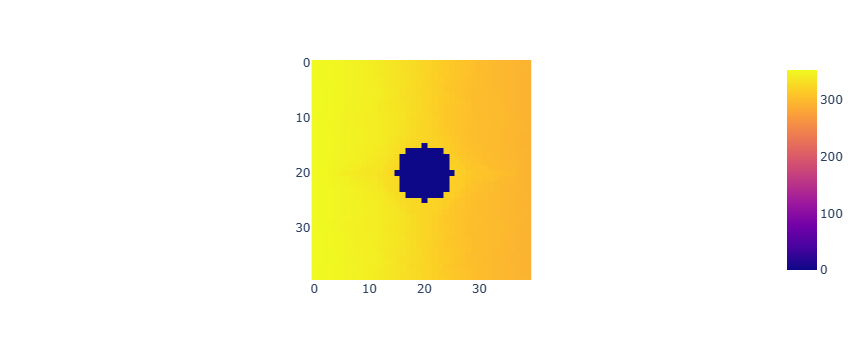

In [114]:
px.imshow(t)